# Images processing

The aim is to generate images for maptcha in a programmatic (automated?) way.
We have the RGB ("true" image from satellite/UAV, `.tif`) and the labels/prediction results (vectorial, so it can be shown "on top" of the RGB, `.geojson`). We want to have a single image out of these 2, a `jpg`, where they are overlaid.

We comprise 2 stages:
1. overlay the two datasets, this would generate a jpg image
2. generate tiles out of the jpg image (possibly on where data exists)


Explaining the point 2: the original images come in tiles, spread across a city/region. See below.

![](../images/screenshot_qgis_desired_output.png)

This is a screenshot of the result we would like to obtain, where actually we would like to have the single tiles saved one by one (the background is the standard OSM layer).

This in Qgis is easy to visualise, but would be tedious to generate the final tiles as an overlaid image.

**...THIRD STAGE?**

We do still need to classify these in false/true and positive/negative.

I see how the labels could help in this, but it seems still less tedious and time-consuming to generate the classification by hand?

... more to think on this.

---

### Data handling

In [ ]:
# need to define an env file too

In [42]:
# Import modules
import os
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
import numpy as np

In [12]:
# Define paths and upload data
basic_path = '/Users/azanchetta/Library/CloudStorage/OneDrive-TheAlanTuringInstitute/Research/projects/Maptcha/data/fair'
image_sample_name = 'OAM-792703-461055-20'

rgb_filename_with_path = f'{basic_path}/rgb/{image_sample_name}.tif'
labels_filename_with_path = f'{basic_path}/labels/{image_sample_name}.geojson'
mask_filename_with_path = f'{basic_path}/masks/{image_sample_name}.mask.tif'
pred_raster_filename_with_path = f'{basic_path}/predictions/{image_sample_name}.tif'
pred_vect_filename_with_path = f'{basic_path}/predictions/prediction_20.geojson'

In [6]:
labels = gpd.read_file(labels_filename_with_path)
pred_vect = gpd.read_file(pred_vect_filename_with_path)

In [37]:
labels.head()

,osm_id,tags,geometry
0,557929722,"{'osm_uid': '1054945', 'building': 'yes', 'osm...","POLYGON ((10258431.592 2416633.417, 10258434.7..."
1,559153834,"{'osm_uid': '1054945', 'building': 'yes', 'osm...","POLYGON ((10258442.167 2416634.265, 10258442.1..."
2,557929723,"{'osm_uid': '6566685', 'building': 'yes', 'osm...","POLYGON ((10258446.765 2416634.742, 10258452.9..."
3,555120925,"{'osm_uid': '6804694', 'building': 'yes', 'osm...","POLYGON ((10258453.856 2416634.253, 10258458.3..."
4,557934116,"{'osm_uid': '3366412', 'building': 'yes', 'osm...","POLYGON ((10258427.261 2416638.790, 10258432.7..."


In [38]:
print(len(labels))

17


In [ ]:
labels.explore()

In [34]:
pred_vect.head()

,geometry
0,"POLYGON ((92.13712 21.20779, 92.13712 21.20779..."
1,"POLYGON ((92.13688 21.20782, 92.13688 21.20783..."
2,"POLYGON ((92.13691 21.20780, 92.13692 21.20782..."
3,"POLYGON ((92.13688 21.20786, 92.13688 21.20787..."
4,"POLYGON ((92.13712 21.20790, 92.13713 21.20790..."


In [39]:
print(len(pred_vect))

163


In [ ]:

pred_vect.explore()

In [13]:
rgb = rasterio.open(rgb_filename_with_path)
mask = rasterio.open(mask_filename_with_path)
pred_raster = rasterio.open(pred_raster_filename_with_path)

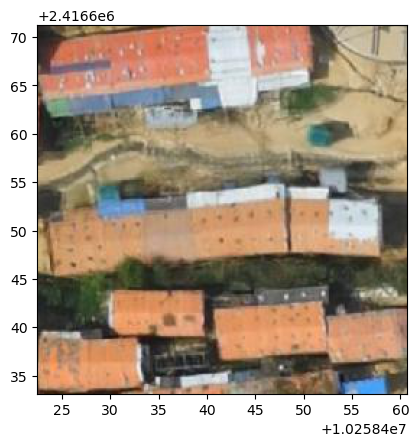

<AxesSubplot: >

In [14]:
show(rgb)

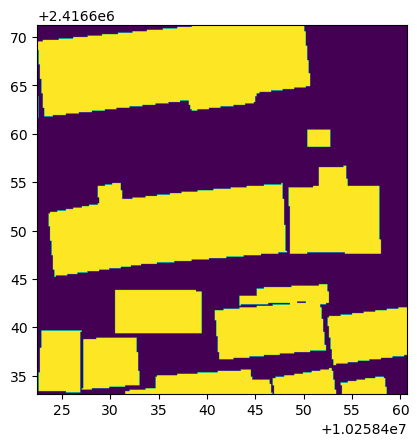

<AxesSubplot: >

In [9]:
show(mask)

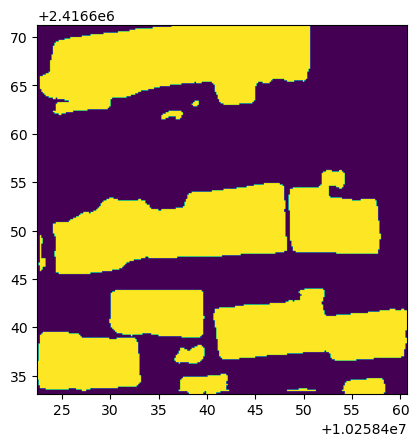

<AxesSubplot: >

In [11]:
show(pred_raster)

### Data processing

In [41]:
type(mask)

rasterio.io.DatasetReader

In [60]:
# Obtain data for T/F P/N
# diff = mask - pred_raster #### too simple!! apparently to subtract rasters we need numpy:
# https://gis.stackexchange.com/questions/463797/calculating-difference-between-two-raster-layers-in-python
mask_np = mask.read(1) #Read first band as a numpy array
pred_raster_np = pred_raster.read(1)

diff = mask_np - pred_raster_np
diff2 = pred_raster_np - mask_np


In [53]:
type(diff)

numpy.ndarray

In [58]:
np.unique(mask_np)

array([0, 1], dtype=uint8)

In [59]:
np.unique(pred_raster_np)

array([  0, 255], dtype=uint8)

In [56]:
np.unique(diff)

array([0, 1, 2], dtype=uint8)

In [62]:
np.unique(diff2)

array([  0, 254, 255], dtype=uint8)

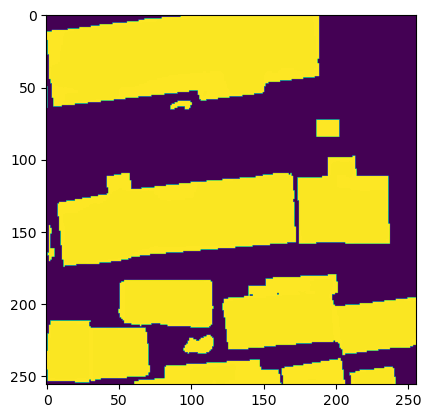

<AxesSubplot: >

In [61]:
show(diff2)

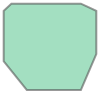

In [24]:
sample_pred = pred_vect['geometry'][3]
sample_pred

In [ ]:
# Script for generating "collapsed" tif and geojson figure
# from https://stackoverflow.com/questions/61980063/how-to-place-a-shapefile-on-top-of-raster-file-in-one-plot-and-then-save-the-pl
import rasterio
import numpy as np
from rasterio import plot as rasterplot
import geopandas as gpd
from matplotlib import pyplot as plt


# this is how you'd open the raster dataset if you have one
#tiff = rasterio.open('example.tif')
#tiff_extent = [tiff.bounds[0], tiff.bounds[2], tiff.bounds[1], tiff.bounds[3]]

# i am making this array up
tiff_band_1 = np.random.randint(0, 10, size=(65, 64))
tiff_extent = [4159200.0, 4808100.0, 2828000.0, 3482600.0]

shapefile = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
shapefile = shapefile.to_crs('epsg:3035')
shapefile = shapefile[shapefile.name == 'Germany']

f, ax = plt.subplots()

# plot DEM
rasterplot.show(
    tiff_band_1,  # use tiff.read(1) with your data
    extent=tiff_extent,
    ax=ax,

)
# plot shapefiles
shapefile.plot(ax=ax, facecolor='w', edgecolor='k')
plt.savefig('test.jpg')
plt.show()

In [ ]:
# Script to separate image in tiles (this cuts the whole image, maybe not relevant)
# https://stackoverflow.com/questions/34940529/fastest-method-of-splitting-image-into-tiles
# https://stackoverflow.com/questions/5953373/how-to-split-image-into-multiple-pieces-in-python